In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'USDC-WETH-3000'
NUMERAIRE_TOKEN = 0
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'  # change to 'H' if you want hourly pool snapshots
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194587 entries, 0 to 194586
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   swap_time                       194587 non-null  datetime64[ns, UTC]
 1   tx_hash                         194587 non-null  string             
 2   token_0_amount                  194587 non-null  float64            
 3   token_1_amount                  194587 non-null  float64            
 4   pool_address                    194587 non-null  string             
 5   price_tick                      194587 non-null  int64              
 6   price_tick_adjusted             194587 non-null  float64            
 7   contract_address_token_0        194587 non-null  string             
 8   contract_name_token_0           194587 non-null  string             
 9   contract_ticker_symbol_token_0  194587 non-null  string             
 

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:40:04+00:00,0x1ad44b6363d4366ed280163f9bfc5db3144eb779e402...,150000.000000,-57.585035,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,197696,0.000385,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 23:10:00+00:00
1,2022-01-29 19:33:47+00:00,0x9617943e5edd58b970f033b5a30fa396e1d11a62caef...,564.934718,-0.216939,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,197701,0.000385,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 23:10:00+00:00
2,2022-01-29 19:33:47+00:00,0x62cc2ebd38f9e7ab1cacae35f2cc56f5732d9cddde5e...,366973.200000,-141.014922,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,197701,0.000385,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 23:10:00+00:00
3,2022-01-29 18:57:16+00:00,0xac72f1402535087d7374ee29d5f4171ba4401e0a8975...,11595.252414,-4.458739,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,197715,0.000386,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 23:10:00+00:00
4,2022-01-29 18:57:16+00:00,0x2416f374116b7abce61ac1cf52542ce4356dbcce5541...,175120.000000,-67.362181,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,197715,0.000386,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 23:10:00+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79402 entries, 0 to 79401
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        79402 non-null  datetime64[ns, UTC]
 1   tx_hash                         79402 non-null  string             
 2   token_0_amount                  79402 non-null  float64            
 3   token_1_amount                  79402 non-null  float64            
 4   pool_address                    79402 non-null  string             
 5   liquidity_event                 79402 non-null  string             
 6   price_tick_lower                79402 non-null  int64              
 7   price_tick_upper                79402 non-null  int64              
 8   price_tick_lower_adjusted       79402 non-null  float64            
 9   price_tick_upper_adjusted       79402 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 19:47:17+00:00,0x677d088726af6ae061a5050fe38c605324fe9505fa11...,39787.600963,0.000000,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,REMOVE_LIQUIDITY,197700,199500,0.000385,0.000461,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x4d35a946c2853db8f40e1ad1599fd48bb176de5a,3000,60,2021-05-04 23:10:00+00:00,-0.009072
1,2022-01-29 19:35:24+00:00,0x2a7a602c8726fdba4872467fd5af9628f3ba1418e6e1...,0.000000,0.000000,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,REMOVE_LIQUIDITY,191580,198900,0.000209,0.000434,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x9bc9e3ae225a91ff907e4ab76349fad5a0d3a7eb,3000,60,2021-05-04 23:10:00+00:00,-0.000000
2,2022-01-29 18:31:26+00:00,0x564b6bb7c392b1f55bc42c73e62c9045e233ac289a41...,270.384808,0.084914,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,REMOVE_LIQUIDITY,191760,205620,0.000213,0.000850,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x3522b690eb07a991a5ca405ab2d8b465d4cc5b10,3000,60,2021-05-04 23:10:00+00:00,-0.000016
3,2022-01-29 16:46:59+00:00,0x649d3244105b674b7185de1440158897f19fd2d0786f...,676.191132,0.280460,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,REMOVE_LIQUIDITY,190740,204600,0.000192,0.000768,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x3db1d6848f2ada4efd1e3a1ce61c7816a0f857a4,3000,60,2021-05-04 23:10:00+00:00,-0.000047
4,2022-01-29 14:43:05+00:00,0x9479c11076c00089e28f7d0dc016acff5c21879f889e...,263.006947,0.103671,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,ADD_LIQUIDITY,190740,204600,0.000192,0.000768,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x3db1d6848f2ada4efd1e3a1ce61c7816a0f857a4,3000,60,2021-05-04 23:10:00+00:00,0.000018


In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-04 23:10:00+00:00,0x89d75075eaef8c21ab215ae54144ba563b850ee7460f...,0.000000,0.010000,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,ADD_LIQUIDITY,192180,193380,0.000222,0.000250,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x3b8ccaa89fcd432f1334d35b10ff8547001ce3e5,3000,60,2021-05-04 23:10:00+00:00,1.086051e-05
1,2021-05-04 23:19:42+00:00,0xa1e74984726029b415fbae234585ce9a58c7d4c0cba3...,50000.000000,9.205484,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,ADD_LIQUIDITY,192660,199800,0.000233,0.000475,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xe14722b5f1aa6ea161e547c5ca598068ec1b3bc0,3000,60,2021-05-04 23:10:00+00:00,4.303370e-03
2,2021-05-05 02:10:21+00:00,0xa4c214dfab7ada5d5238315417c6b20baf23238f3a25...,167.505955,0.044750,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,ADD_LIQUIDITY,195060,195540,0.000296,0.000310,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,3000,60,2021-05-04 23:10:00+00:00,2.299857e-04
3,2021-05-05 02:21:03+00:00,0x7fe874f7c97a0ffb06b57a851e19515f0efed73e341d...,0.010000,0.000003,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,ADD_LIQUIDITY,195060,195540,0.000296,0.000310,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,3000,60,2021-05-04 23:10:00+00:00,1.373000e-08
4,2021-05-05 11:27:48+00:00,0x14ebbcc8f2ba2a235570522dc37b125b0216adf5750a...,89.010654,0.016381,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,ADD_LIQUIDITY,177120,276300,0.000049,0.997600,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x53797a73169c9cec4b573db7139703152fe9e41d,3000,60,2021-05-04 23:10:00+00:00,1.576574e-06


In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x89d75075eaef8c21ab215ae54144ba563b850ee7460f89b2a175fd0e267ed330


In [8]:
# from https://etherscan.io/tx/0x89d75075eaef8c21ab215ae54144ba563b850ee7460f89b2a175fd0e267ed330#eventlog
liquidity_delta = amount_to_float('10860507277202', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

# can't calculate the pool's initial price as the tick range doesn't span the price
# i.e., only one token is added to the pool
# token0 = adds.at[0, 'token_0_amount']
# token1 = adds.at[0, 'token_1_amount']
# tick_lower = adds.at[0, 'price_tick_lower']
# tick_upper = adds.at[0, 'price_tick_upper']
# token0_decimals = adds.at[0, 'contract_decimals_token_0']
# token1_decimals = adds.at[0, 'contract_decimals_token_1']

# init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
#                              token0_decimals, token1_decimals)

# token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
# token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
# print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
# print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

In [9]:
sqrt_price_x96 = 1377930981022373588153883738259818
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
init_price = etherscan_price
# print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Price per Etherscan:      3.024793716115e+08


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,79401,0x89d75075eaef8c21ab215ae54144ba563b850ee7460f...,2021-05-04 23:10:00+00:00,ADD_LIQUIDITY
1,79400,0xa1e74984726029b415fbae234585ce9a58c7d4c0cba3...,2021-05-04 23:19:42+00:00,ADD_LIQUIDITY
2,194586,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,2021-05-05 01:56:23+00:00,SWAP
3,79399,0xa4c214dfab7ada5d5238315417c6b20baf23238f3a25...,2021-05-05 02:10:21+00:00,ADD_LIQUIDITY
4,79398,0x7fe874f7c97a0ffb06b57a851e19515f0efed73e341d...,2021-05-05 02:21:03+00:00,ADD_LIQUIDITY
...,...,...,...,...
273112,765,0x01ec8a3e1b78c9dae24421cd5b646ede91e00c244d30...,2022-01-27 23:49:16+00:00,SWAP
273113,762,0xfd8c91be6fdad17f15ff756f8cd78b63c0968238d75d...,2022-01-27 23:53:22+00:00,SWAP
273114,761,0xf00c8f30153a8cbd6fdf0d3c54af53cde4ae7926cca1...,2022-01-27 23:53:59+00:00,SWAP
273115,760,0x48b4a65c8336dfcdb0e657f0e6d84860e1301339e328...,2022-01-27 23:56:12+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-8, 'rtol': 1e-5}
TOKEN1_TOLS = {'atol': 1e-8, 'rtol': 1e-5}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

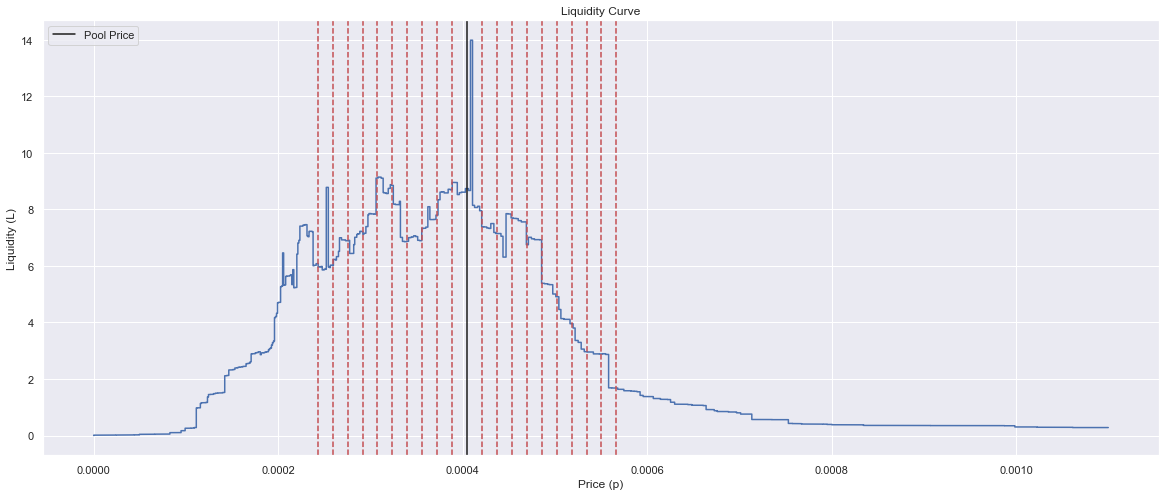

In [13]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 0.001), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

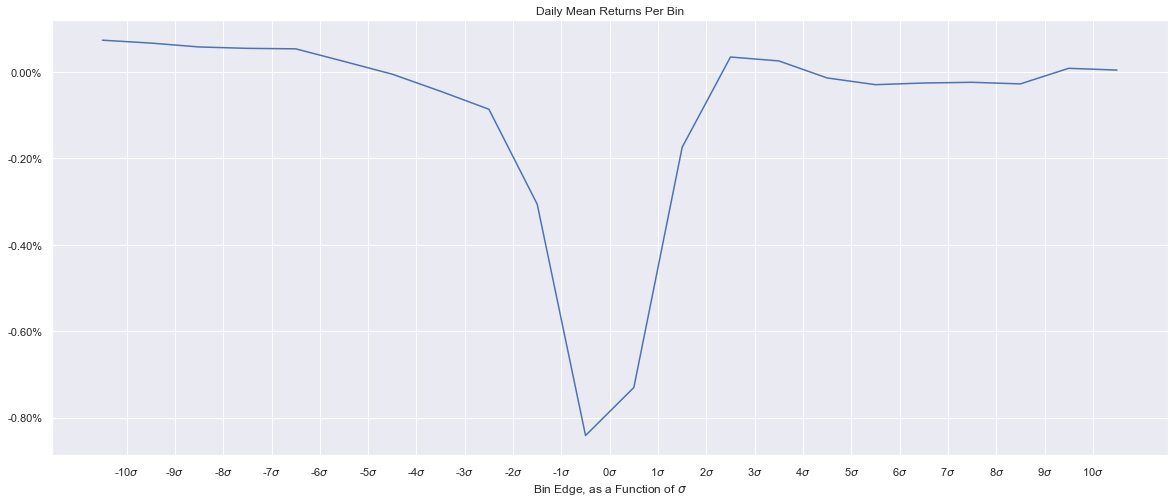

CPU times: user 13min 18s, sys: 12.7 s, total: 13min 31s
Wall time: 13min 39s


In [14]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

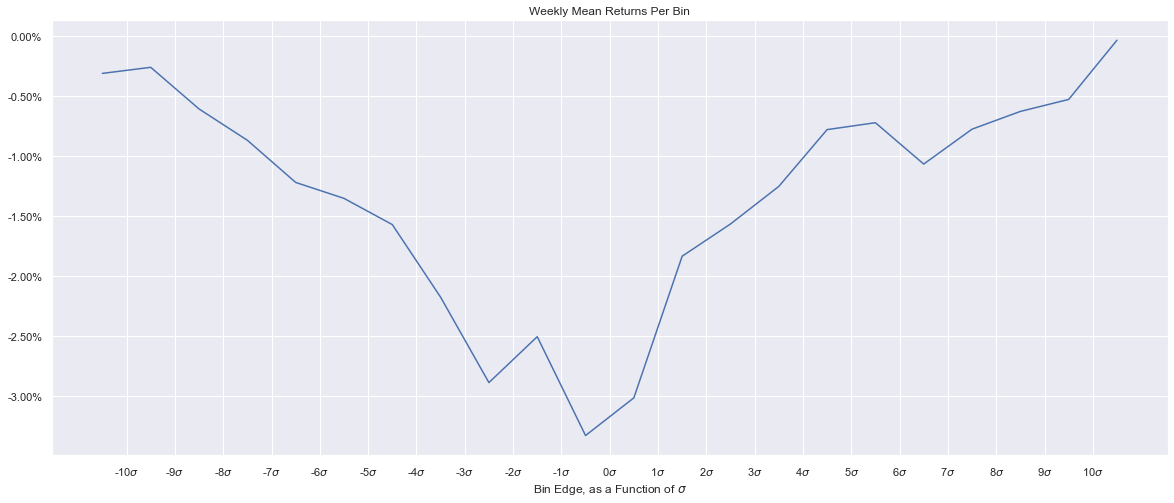

CPU times: user 3min 29s, sys: 4.51 s, total: 3min 34s
Wall time: 3min 36s


In [15]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Weekly Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [16]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Hourly Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()